In [6]:
!ls

Dockerfile  docker-compose.yaml  overrides.json
README.md   notebooks		 requirements.txt


In [2]:
import re
from music21 import *
import os
import pandas as pd

def get_subfolders_names(path):
    return [x[0] for x in os.walk(path)]

def get_files_with_prefix(path, prefix):
    return [each for each in os.listdir(path) if each.startswith(prefix)]

def read_files_in_directory(path, prefix):
    files = get_files_with_prefix(path, prefix)
    contents = []
    for file in files:
        with open(path+'/'+file, 'r') as f:
            content = f.read()
            contents.append(content)
    return dict(zip(files,contents))
    
def get_songs_from_sample(sample):
    sample_split = '---------------\n'
    current_songs= sample.split(sample_split)[:-1]
    ignore_lines =5
    current_song = ''
    initial_song = '\n'.join(current_songs[0].splitlines()[5:7])
    remaining_songs = current_songs[1:]
    remaining_songs = ['\n'.join(sample_song.splitlines()[:2]) for sample_song in remaining_songs]
    song_samples = [initial_song]+remaining_songs
    print('num. song samples:',len(song_samples))
    return song_samples

def insert_new_line_nth_bar(song_body,nth_bar=4):
    count_bars = 0
    new_body = ''
    for current_char in song_body:
        new_body = new_body+current_char
        if current_char=='|':
            count_bars+=1
            if count_bars%4==0:
                new_body = new_body+'\n'
    return new_body

def format_model_output(abc_song_model_output,add_new_lines_to_body=True):
    header_chars = ['M','L','K']
    pattern = re.compile(r'([{}])'.format(''.join(header_chars)))
    formatted_song = pattern.sub(r' \1', abc_song_model_output)
        
    #print(formatted_song.split())
    header_M,header_L,aux_header_K,song_body= formatted_song.split()
    if(add_new_lines_to_body):
        song_body = insert_new_line_nth_bar(song_body)
    index = aux_header_K.find('|')
    header_K = aux_header_K[:index]
    header_comment = '%'+aux_header_K[index:]
    song_metadata = [header_M,header_L,header_K,header_comment,song_body]
    formatted_song = '\n'.join(song_metadata)
    
    return dict(zip(['M','L','K','chord_prog','song_body'],song_metadata)),formatted_song

def parse_abc_song(formatted_abc_song):
    chars_in_quotes = r'\".*?\"'
    formatted_abc_song_no_quotes = re.sub(chars_in_quotes, '', formatted_abc_song)
    return converter.parse(formatted_abc_song_no_quotes, format='abc')

def get_song_key_obj(song_metadata):
    song_key_metadata = abcFormat.ABCMetadata(song_metadata['K'])
    song_key_metadata.preParse()
    return song_key_metadata.getKeySignatureObject()

def get_song_notes(formatted_abc_string):
    parsed_abc_song = converter.parse(formatted_abc_string, format='abc')
    current_pitches = parsed_abc_song.pitches
    return current_pitches
    
def get_song_key(song_stream):
    return song_stream.analyze('key')

def metric_notes_in_key_rate(parsed_abc_song,key_song_obj):
    song_notes = [pitch.name for pitch in parsed_abc_song.pitches]
    key_notes = [key_pitch.name for key_pitch in key_song_obj.pitches]

    total_notes = len(song_notes)

    notes_in_key = 0
    notes_not_in_key = 0
    rate = 0
    for current_note in song_notes:
        if current_note in key_notes:
            notes_in_key += 1
        else:
            notes_not_in_key += 1

    if notes_in_key !=0:    
        rate = notes_in_key/total_notes 
    metric_data = {
        'notes_in_key_rate':rate,
        'total_notes':total_notes,
        'notes_in_key':notes_in_key,
        'notes_not_in_key':notes_not_in_key
    }
    return metric_data

def get_bars_length_diff(abc_song_body,chord_prog):
    chord_prog_bars = len(chord_prog.split('|'))
    song_bars = len(abc_song_body.split('|'))
    return abs(song_bars-chord_prog_bars)

def get_metrics(formatted_abc_song,song_metadata):
    
    parsed_song = parse_abc_song(formatted_abc_song)
    current_key = get_song_key_obj(song_metadata)
    
    metric_data = metric_notes_in_key_rate(parsed_song,current_key)
    metric_data["get_bars_length_diff"] = get_bars_length_diff(song_metadata['song_body'],song_metadata["chord_prog"])
    return metric_data


In [11]:

header = '%|"Am"|"Dm"|"E"|"E"|"Am"|"Dm"|"E"|"Am"|]'
song = 'e|"Am"A/2c/2c/2c/2c/2B/2c/2A/2|||"Am"A/2c/2c/2c/2c/2B/2c/2A/2|'

get_bars_length_diff(song,header)

4

In [13]:
other_abc_string = """
X:1
T:Example
M:4/4
L:1/4
K:G
"G"G/2A/2B/2A/2G/2F/2|G/2A/2B/2A/2G/2F/2|"IV"E3/4F/4G/2E/2|C/2C/2C/2|"V"B,2|"I"G/2A/4G/2F/2E/2|"IV"C/2C/2C/2D/2E/2|"V"F/2B,/2D/2C/2B,/2|"I"G/2G/2G/2A/2|"IV"G/2A/4G/4F/4G/2|"V"F/2G/2F/2D/2|"I"E2|]
"""
current_song_metadata, current_song_formatted = format_model_output(other_abc_string)
examples_stream = stream.Stream()
abc_scores = [current_song_formatted]
streams = []
for abc_song in abc_scores:
    print('-----'*5)
    parsed_abc_song = converter.parse(abc_song, format='abc')
    examples_stream.insert(examples_stream.highestTime, parsed_abc_song)
    current_key = parsed_abc_song.analyze('key')
    current_key_pitches = [key_pitch.name for key_pitch in current_key.pitches]
    current_pitches = parsed_abc_song.pitches
    count_pitches_in_key = 0
    count_pitches_not_in_key = 0
    for pitch in current_pitches:
        if pitch.name in current_key_pitches:
            count_pitches_in_key += 1
        else:
            count_pitches_not_in_key += 1
    print('Key',current_key.name)
    print('In Key: ', count_pitches_in_key)
    print('Not in Key:', count_pitches_not_in_key)
    print('-----'*5)
examples_stream.plot('histogram', 'pitchClass')

ValueError: too many values to unpack (expected 4)

<music21.graph.plot.HistogramPitchSpace for <music21.stream.Stream 0x7f4613f6bcd0>>

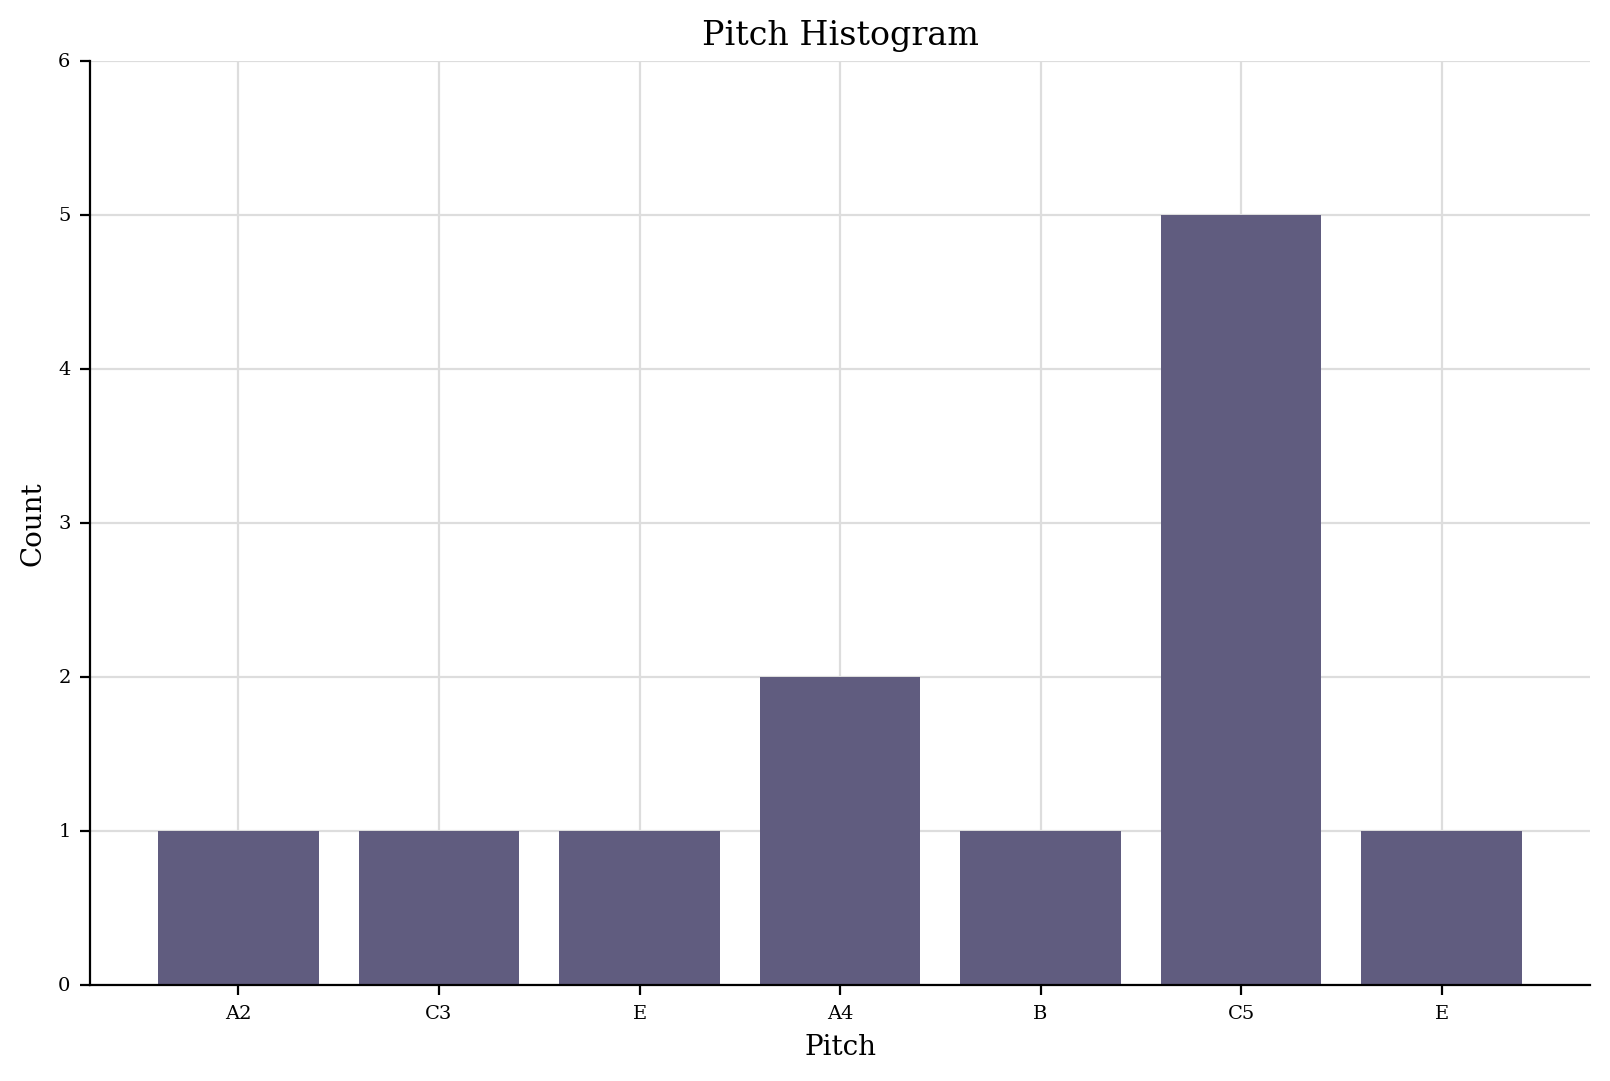

In [21]:
examples_stream.plot('histogram', 'pitch')

In [2]:
def get_songs_from_dataset(tuneBook):
    songs_in_tuneBook=tuneBook.split('\n\n')[:-1]
    return songs_in_tuneBook

def get_song_metadata(formatted_song):
    header_M,header_L,header_K,aux_header_K,song_body= formatted_song.split('\n')
    header_comment = '%'+aux_header_K
    song_metadata = [header_M,header_L,header_K,header_comment,song_body]
    formatted_song = '\n'.join(song_metadata)
    return dict(zip(['M','L','K','chord_prog','song_body'],song_metadata)),formatted_song
my_tuneBook = '''M:4/4
L:1/4
K:Bm
|"i"|"i"|"VII"|"VII"|"i"|"i"|"V"|"i"|"i"|"i"|"VII"|"VII"|"i""VII"|"i""V"|"iv""V"|"i"|]
F|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|"VII"AAA,A,/2B,/2|"VII"C/2E/2A/2F/2E/2C/2B,/2A,/2|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|A/2G/2F/2E/2"V"F/2E/2D/2C/2|"i"B,2B,|F|"i"FBB3/2A/2|"i"F/2A/2B/2c/2d/2c/2B/2A/2|"VII"EAA3/2F/2|"VII"E/2F/2A/2B/2c/2B/2A/2c/2|"i"BF"VII"dF|"i"eF"V"f3/2e/2|"iv"d/2c/2B/2A/2"V"F/2d/2c/2d/2|"i"B2B|]

M:4/4
L:1/4
K:A
|"I"|"ii""V"|"I"|"V""I"|"I"|"ii"|"V"|"I"|"I"|"ii"|"V"|"I"|"IV""V"|"I"|"V"|"I"|"II"|"V"|"I"|"ii"|"I""V"|"I"|]
E|"I"AECE|"ii"FD"V"B,D|"I"CEA3/2B/2|"V"c/2d/2c/2B/2"I"AE|"I"AECE|"ii"FDB,D|"V"C3/2B,/2A,G,|"I"A,3C/2D/2|"I"E3/2D/2CD|EAcE|"ii"FAdc|"V"B/2c/2B/2A/2GC/2D/2|"I"E3/2D/2CD|EAcE|"IV"Fd"V"c/2B/2A/2G/2|"I"A3G/2A/2|"V"B3/2G/2EE|"I"c3/2A/2EE|"II"^dBcd|"V"edcB|"I"AECE|"ii"FDB,D|"I"CE"V"A3/2B/2|"I"A3|]

'''
songs_in_tunebook = get_songs_from_dataset(my_tuneBook)

metadata_in_tunebook, formatted_song_tunebook = get_song_metadata(songs_in_tunebook[0])
print(metadata_in_tunebook)
print(formatted_song_tunebook)
print(get_bars_length_diff(metadata_in_tunebook['song_body'],metadata_in_tunebook['chord_prog']))

{'M': 'M:4/4', 'L': 'L:1/4', 'K': 'K:Bm', 'chord_prog': '%|"i"|"i"|"VII"|"VII"|"i"|"i"|"V"|"i"|"i"|"i"|"VII"|"VII"|"i""VII"|"i""V"|"iv""V"|"i"|]', 'song_body': 'F|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|"VII"AAA,A,/2B,/2|"VII"C/2E/2A/2F/2E/2C/2B,/2A,/2|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|A/2G/2F/2E/2"V"F/2E/2D/2C/2|"i"B,2B,|F|"i"FBB3/2A/2|"i"F/2A/2B/2c/2d/2c/2B/2A/2|"VII"EAA3/2F/2|"VII"E/2F/2A/2B/2c/2B/2A/2c/2|"i"BF"VII"dF|"i"eF"V"f3/2e/2|"iv"d/2c/2B/2A/2"V"F/2d/2c/2d/2|"i"B2B|]'}
M:4/4
L:1/4
K:Bm
%|"i"|"i"|"VII"|"VII"|"i"|"i"|"V"|"i"|"i"|"i"|"VII"|"VII"|"i""VII"|"i""V"|"iv""V"|"i"|]
F|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|"VII"AAA,A,/2B,/2|"VII"C/2E/2A/2F/2E/2C/2B,/2A,/2|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|A/2G/2F/2E/2"V"F/2E/2D/2C/2|"i"B,2B,|F|"i"FBB3/2A/2|"i"F/2A/2B/2c/2d/2c/2B/2A/2|"VII"EAA3/2F/2|"VII"E/2F/2A/2B/2c/2B/2A/2c/2|"i"BF"VII"dF|"i"eF"V"f3/2e/2|"iv"d/2c/2B/2A/2"V"F/2d/2c/2d/2|"i"B2B|]
1


10
10


In [11]:
def analyse_abc_songs(experiments,experiments_prefix='examples',is_experiment=True,format_songs=False):
    experiment_errors = {}
    total_errors_count = 0
    metrics_df = pd.DataFrame()
    experiment_name_and_location = experiments.items()
    for experiment_name,experiment_path in experiment_name_and_location:
        experiment_samples = read_files_in_directory(experiment_path,experiments_prefix)
        
        print(experiment_name)
        sample_errors = {}
        sample_errors_count = 0

        for sample_name in experiment_samples.keys():
            experiment_example = experiment_samples[sample_name]
            if is_experiment:
                print(sample_name)
            if is_experiment:
                sample_songs = get_songs_from_sample(experiment_example)
            else:
                sample_songs = get_songs_from_dataset(experiment_example)

            for sample in sample_songs:
                try:
                    if is_experiment:
                        metadata, formatted_sample = format_model_output(sample)
                    else:
                        metadata, formatted_sample = get_song_metadata(sample)
                        
                    current_metric = get_metrics(formatted_sample,metadata)

                    current_metric['song_formatted'] = formatted_sample
                    current_metric['sample_name'] = sample_name
                    current_metric['experiment_name'] = experiment_name
                    current_metric['M'] = metadata['M']
                    current_metric['K'] = metadata['K']
                    metrics_row = pd.DataFrame([current_metric])    
                    metrics_df = pd.concat([metrics_df, metrics_row])               
                except Exception as e:
                    print('Error Found!!!')
                    sample_errors_count += 1
                    if sample_name in sample_errors:
                        sample_errors[sample_name].append(f'caught {type(e)}: e')
                    else:
                        sample_errors[sample_name] = [f'caught {type(e)}: e']
        
        experiment_errors[experiment_name] = sample_errors
        print('errors_in_sample:',sample_errors_count)
        total_errors_count += sample_errors_count
        print('-----'*10)
    print('total_errors:',total_errors_count)
    return experiment_errors,metrics_df
    
def load_dataframe(relative_path,dataframe_name):
    df = pd.read_pickle(f'{relative_path}/{dataframe_name}.pkl')    
    return df

def save_dataframe(df,relative_path,file_name):
    reorder_columns = df.columns.sort_values(ascending=False)
    df_to_be_saved = df[reorder_columns]
    print(file_name," dataset shape",df_to_be_saved.shape)
    print(df_to_be_saved.columns)
    print("-"*10)
    df_to_be_saved.to_pickle(f'{relative_path}/{file_name}.pkl')

In [12]:
experiments_main_path = './notebooks/nanoGPT/older_ckpt/'
experiments_paths = get_subfolders_names(experiments_main_path)[1:]    
experiments = {path.split('/')[-1]:path for path in experiments_paths}
experiments
errors_found,experiments_metrics_df = analyse_abc_songs(experiments)

hd-8-ly-12-embd-240
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-embd-280
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-embd-368
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd_8_ly_6_bch_84
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-embd-320
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
---------------------------------------

abcFormat: WARNING: Could not get pitch information from note:  ^, assuming C


examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-bt-1
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-rn-data
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-12-ly-12-rn-data
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
Error Found!!!
errors_in_sample: 1
--------------------------------------------------
hd-8-ly-12-bt-64
examples_C.txt
num. song samples: 10
examples_G.txt
num. song

In [13]:
datasets_main_path = './notebooks/nanoGPT/data/'
datasets_paths = get_subfolders_names(datasets_main_path)[1:]    
original_data_paths = {path.split('/')[-1]:path for path in datasets_paths}
original_data_paths

{'abc_roman_num_char': './notebooks/nanoGPT/data/abc_roman_num_char',
 'abc_char': './notebooks/nanoGPT/data/abc_char'}

In [6]:
errors_found,original_data_metrics_df = analyse_abc_songs(original_data_paths,
                                experiments_prefix='input',
                                is_experiment=False)

abc_roman_num_char
errors_in_sample: 0
--------------------------------------------------
abc_char
errors_in_sample: 0
--------------------------------------------------
total_errors: 0


In [19]:
print(experiments_metrics_df.song_formatted.iloc[0])

M:4/4
L:1/4
K:C
%|"C"|"F"|"G"|"G"|"C"|"F"|"G"|"C"|]
GF|"C"E2EE|"F"F2A3/2A/2|"G"BGGA|
"C"AGGA|"C"cccd/2e/2|"F"fAGF|"G"GBGA|
"C"cc3|"F"cde|"G"dg/2e/2f/2e/2d/2|"C"c2c3/2e/2|
"F"fAGF|"G"GBGA|"C"ccc|]


## Save Data

In [137]:
!ls

Dockerfile  docker-compose.yaml  overrides.json
README.md   notebooks		 requirements.txt


In [20]:
relative_path = './notebooks/nanoGPT/results'
file_name= 'experiments_metrics'
save_dataframe(experiments_metrics_df,relative_path,file_name)

experiments_metrics  dataset shape (659, 8)
Index(['total_notes', 'song_formatted', 'sample_name', 'notes_not_in_key',
       'notes_in_key_rate', 'notes_in_key', 'get_bars_length_diff',
       'experiment_name'],
      dtype='object')
----------


In [21]:
relative_path = './notebooks/nanoGPT/results'
file_name= 'original_data_metrics'
save_dataframe(original_data_metrics_df,relative_path,file_name)

original_data_metrics  dataset shape (19000, 8)
Index(['total_notes', 'song_formatted', 'sample_name', 'notes_not_in_key',
       'notes_in_key_rate', 'notes_in_key', 'get_bars_length_diff',
       'experiment_name'],
      dtype='object')
----------


## Experiments Analysis

In [4]:
relative_path = './notebooks/nanoGPT/results'
file_name = 'experiments_metrics'
experiments_metrics_df = load_dataframe(relative_path=relative_path,dataframe_name=file_name)
file_name = 'original_data_metrics'
original_data_metrics_df = load_dataframe(relative_path=relative_path,dataframe_name=file_name)

In [5]:
original_data_metrics_df.groupby('experiment_name').agg('mean')

/tmp/ipykernel_121/3509641324.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  original_data_metrics_df.groupby('experiment_name').agg('mean')


,total_notes,notes_not_in_key,notes_in_key_rate,notes_in_key,get_bars_length_diff
experiment_name,,,,,
abc_char,100.515480,1.605939,0.984908,98.909541,1.935868
abc_roman_num_char,100.532828,1.606376,0.984906,98.926452,1.935606


In [24]:
print(original_data_metrics_df.groupby('experiment_name').agg('mean').to_csv())

experiment_name,total_notes,notes_not_in_key,notes_in_key_rate,notes_in_key,get_bars_length_diff
abc_char,100.51548020219039,1.6059393428812132,0.984907634919812,98.90954085930919,1.9358677337826453
abc_roman_num_char,100.53282828282828,1.6063762626262625,0.9849064911999941,98.92645202020202,1.9356060606060606



/tmp/ipykernel_121/1313913997.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(original_data_metrics_df.groupby('experiment_name').agg('mean').to_csv())


In [6]:
experiments_metrics_df.groupby('experiment_name').agg('mean')

/tmp/ipykernel_121/3858133082.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  experiments_metrics_df.groupby('experiment_name').agg('mean')


,total_notes,notes_not_in_key,notes_in_key_rate,notes_in_key,get_bars_length_diff
experiment_name,,,,,
embd_396,92.200000,0.466667,0.995007,91.733333,10.300000
hd-12-ly-12,97.800000,1.900000,0.982656,95.900000,13.233333
hd-12-ly-12-rn-data,69.433333,0.833333,0.987486,68.600000,6.000000
hd-8-ly-12,89.896552,1.034483,0.986786,88.862069,6.965517
hd-8-ly-12-bt-1,83.900000,1.300000,0.989421,82.600000,10.200000
hd-8-ly-12-bt-16,98.233333,5.566667,0.956097,92.666667,12.033333
hd-8-ly-12-bt-4,96.000000,1.433333,0.983279,94.566667,10.000000
hd-8-ly-12-bt-4-ctx-1024,105.066667,1.500000,0.988776,103.566667,11.700000
hd-8-ly-12-bt-4-ctx-256,95.433333,0.666667,0.993037,94.766667,9.500000


In [9]:
from dotenv import load_dotenv
import os
import wandb

env_path = './notebooks/.env'
load_dotenv(env_path)

#wandb_api_key = os.getenv('WANDB_API_KEY')


True

In [10]:
api = wandb.Api()
entity, project = "davidnogales", "abc-char"  
runs = api.runs(entity + "/" + project) 

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains output keys/values for 
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)



wandb_runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })


wandb_runs_df

,summary,config,name
0,"{'lr': 0.00034283422302689896, '_step': 522, '...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-8-ly-12-bt4-rn-data-ovrf
1,"{'train/loss': 0.04077206924557686, 'lr': 0.00...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-8-ly-12-bt4-ovrf
2,"{'lr': 0.0009335586201027058, 'val/loss': 0.60...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-12-ly-12-rn-data
3,"{'mfu': 2.48183042695255, 'iter': 960, '_step'...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-8-ly-16-rn-data
4,"{'val/loss': 0.5168594121932983, 'lr': 0.00093...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-8-ly-12-rn-data
5,"{'train/loss': 0.2879921793937683, 'lr': 0.000...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-8-ly-12-bt-4-rn-data
6,"{'lr': 0.0008266013891893416, '_step': 145, '_...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-8-ly-12-bt-4-ctx-1024
7,"{'lr': 0.0005959117571337929, 'mfu': 1.2324993...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-8-ly-12-bt-4-ctx-256
8,"{'val/loss': 0.4741564393043518, 'lr': 0.00036...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-8-ly-12-bt-1
9,"{'_runtime': 2967.664024591446, '_timestamp': ...","{'bias': False, 'beta1': 0.9, 'beta2': 0.99, '...",mini-char-gpt-hd-8-ly-12-bt-4


In [18]:
df = wandb_runs_df
df = pd.concat([df.drop('summary', axis=1), df['summary'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop('config', axis=1), df['config'].apply(pd.Series)], axis=1)
df = pd.concat([df.drop('_wandb', axis=1), df['_wandb'].apply(pd.Series)], axis=1)
print(df.columns)
useful_columns = ['name','n_layer','n_head','batch_size','n_embd','block_size','train/loss','val/loss','time (h)']
df['time (h)'] = df['_runtime']/3600
df[useful_columns]

Index([                       'name',                          'lr',
                             '_step',                    '_runtime',
                        '_timestamp',                         'mfu',
                              'iter',                    'val/loss',
                        'train/loss',                        'bias',
                             'beta1',                       'beta2',
                             'dtype',                      'device',
                            'min_lr',                      'n_embd',
                            'n_head',                     'backend',
                           'compile',                     'dataset',
                           'dropout',                     'n_layer',
                           'out_dir',                    'decay_lr',
                         'eval_only',                   'grad_clip',
                         'init_from',                   'max_iters',
                         'wandb_lo

,name,n_layer,n_head,batch_size,n_embd,block_size,train/loss,val/loss,time (h)
0,mini-char-gpt-hd-8-ly-12-bt4-rn-data-ovrf,12,8,4,384,512,0.041966,0.060936,3.004263
1,mini-char-gpt-hd-8-ly-12-bt4-ovrf,12,8,4,384,512,0.040772,0.162197,3.007017
2,mini-char-gpt-hd-12-ly-12-rn-data,12,12,32,384,512,0.556676,0.603302,3.227555
3,mini-char-gpt-hd-8-ly-16-rn-data,16,8,32,384,512,0.319896,0.418804,4.766791
4,mini-char-gpt-hd-8-ly-12-rn-data,12,8,32,384,512,0.451124,0.516859,3.372675
5,mini-char-gpt-hd-8-ly-12-bt-4-rn-data,12,8,4,384,512,0.287992,0.372312,0.928683
6,mini-char-gpt-hd-8-ly-12-bt-4-ctx-1024,12,8,4,384,1024,0.247996,0.410028,1.745746
7,mini-char-gpt-hd-8-ly-12-bt-4-ctx-256,12,8,4,384,256,0.235695,0.431453,1.001317
8,mini-char-gpt-hd-8-ly-12-bt-1,12,8,1,384,512,0.357693,0.474156,1.345786
9,mini-char-gpt-hd-8-ly-12-bt-4,12,8,4,384,512,0.283366,0.426364,0.824351


In [22]:
df['time (h)'].sum()

87.93160674333573

In [19]:
def even_number_background(cell_value):

    highlight = 'background-color: darkorange;'
    default = ''

    if type(cell_value) in [float, int]:
        if cell_value % 2 == 0:
            return highlight
    return default

df[useful_columns].style.applymap(even_number_background)

df[useful_columns].style.format(precision=3, thousands=".", decimal=",")

,name,n_layer,n_head,batch_size,n_embd,block_size,train/loss,val/loss,time (h)
0,mini-char-gpt-hd-8-ly-12-bt4-rn-data-ovrf,12,8,4,384,512,"0,042","0,061","3,004"
1,mini-char-gpt-hd-8-ly-12-bt4-ovrf,12,8,4,384,512,"0,041","0,162","3,007"
2,mini-char-gpt-hd-12-ly-12-rn-data,12,12,32,384,512,"0,557","0,603","3,228"
3,mini-char-gpt-hd-8-ly-16-rn-data,16,8,32,384,512,"0,320","0,419","4,767"
4,mini-char-gpt-hd-8-ly-12-rn-data,12,8,32,384,512,"0,451","0,517","3,373"
5,mini-char-gpt-hd-8-ly-12-bt-4-rn-data,12,8,4,384,512,"0,288","0,372","0,929"
6,mini-char-gpt-hd-8-ly-12-bt-4-ctx-1024,12,8,4,384,1.024,"0,248","0,410","1,746"
7,mini-char-gpt-hd-8-ly-12-bt-4-ctx-256,12,8,4,384,256,"0,236","0,431","1,001"
8,mini-char-gpt-hd-8-ly-12-bt-1,12,8,1,384,512,"0,358","0,474","1,346"
9,mini-char-gpt-hd-8-ly-12-bt-4,12,8,4,384,512,"0,283","0,426","0,824"


In [20]:
print(df[useful_columns].to_csv())

,name,n_layer,n_head,batch_size,n_embd,block_size,train/loss,val/loss,time (h)
0,mini-char-gpt-hd-8-ly-12-bt4-rn-data-ovrf,12,8,4,384,512,0.04196591675281525,0.06093587353825569,3.0042626030577555
1,mini-char-gpt-hd-8-ly-12-bt4-ovrf,12,8,4,384,512,0.04077206924557686,0.16219723224639893,3.0070166044765045
2,mini-char-gpt-hd-12-ly-12-rn-data,12,12,32,384,512,0.5566761493682861,0.6033019423484802,3.2275549712446
3,mini-char-gpt-hd-8-ly-16-rn-data,16,8,32,384,512,0.31989648938179016,0.418804407119751,4.766790787312719
4,mini-char-gpt-hd-8-ly-12-rn-data,12,8,32,384,512,0.4511236548423767,0.5168594121932983,3.372674682206578
5,mini-char-gpt-hd-8-ly-12-bt-4-rn-data,12,8,4,384,512,0.2879921793937683,0.3723118007183075,0.9286833186944325
6,mini-char-gpt-hd-8-ly-12-bt-4-ctx-1024,12,8,4,384,1024,0.2479955703020096,0.41002777218818665,1.7457458392116758
7,mini-char-gpt-hd-8-ly-12-bt-4-ctx-256,12,8,4,384,256,0.23569494485855105,0.431452989578247,1.0013165222936207
8,mini-char-gpt-hd-8-ly-12-bt-1,1

## Bulk Samples Analysis

In [121]:
experiments_main_path = './notebooks/nanoGPT/best_models/'
experiments_paths = get_subfolders_names(experiments_main_path)[1:]    
experiments = {path.split('/')[-1]:path for path in experiments_paths}
experiments
errors_found,bulk_samples_metrics_df = analyse_abc_songs(experiments)

hd-8-ly-12-bt4-rn-data-ovrf
examples_C34.txt
num. song samples: 50
Error Found!!!
examples_A.txt
num. song samples: 50
Error Found!!!
examples_C.txt
num. song samples: 100
Error Found!!!
examples_Cm.txt
num. song samples: 100
Error Found!!!


abcFormat: WARNING: Could not get pitch information from note:  I, assuming C
abcFormat: WARNING: Could not get pitch information from note:  ^, assuming C


examples_A34.txt
num. song samples: 50
Error Found!!!
examples_Am.txt
num. song samples: 100
Error Found!!!
examples_Cm34.txt
num. song samples: 50
Error Found!!!


abcFormat: WARNING: Could not get pitch information from note:  ^, assuming C
abcFormat: WARNING: Could not get pitch information from note:  i, assuming C


examples_Am34.txt
num. song samples: 50
Error Found!!!
errors_in_sample: 8
--------------------------------------------------
hd-8-ly-12-bt4-ovrf
examples_C.txt
num. song samples: 100
Error Found!!!
examples_Am.txt
num. song samples: 100
Error Found!!!
errors_in_sample: 2
--------------------------------------------------
total_errors: 10


In [19]:
bulk_samples_metrics_df.groupby('experiment_name').agg('median')

/tmp/ipykernel_13/1552938583.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bulk_samples_metrics_df.groupby('experiment_name').agg('median')


,notes_in_key_rate,total_notes,notes_in_key,notes_not_in_key,get_bars_length_diff
experiment_name,,,,,
hd-8-ly-12-bt4-ovrf,1.0,66.0,64.0,0.0,3.0
hd-8-ly-12-bt4-rn-data-ovrf,1.0,69.0,67.0,0.0,7.0


In [20]:
bulk_samples_metrics_df.groupby('experiment_name').agg('mean')

/tmp/ipykernel_13/553775211.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bulk_samples_metrics_df.groupby('experiment_name').agg('mean')


,notes_in_key_rate,total_notes,notes_in_key,notes_not_in_key,get_bars_length_diff
experiment_name,,,,,
hd-8-ly-12-bt4-ovrf,0.97333,64.813131,63.136364,1.676768,5.636364
hd-8-ly-12-bt4-rn-data-ovrf,0.97446,67.267677,65.383838,1.883838,6.883838


In [21]:
n = 2
groups = ['experiment_name','sample_name']
random_sample = bulk_samples_metrics_df.groupby(groups).apply(lambda x: x.sample(n)).reset_index(drop=True)
random_sample[['song_formatted','experiment_name','sample_name']]

,song_formatted,experiment_name,sample_name
0,"M:4/4\nL:1/4\nK:Am\n%|""Am""|""Dm""|""E""|""E""|""Am""|""...",hd-8-ly-12-bt4-ovrf,examples_Am.txt
1,"M:4/4\nL:1/4\nK:Am\n%|""Am""|""Dm""|""E""|""E""|""Am""|""...",hd-8-ly-12-bt4-ovrf,examples_Am.txt
2,"M:4/4\nL:1/4\nK:C\n%|""C""|""F""|""G""|""G""|""C""|""F""|""...",hd-8-ly-12-bt4-ovrf,examples_C.txt
3,"M:4/4\nL:1/4\nK:C\n%|""C""|""F""|""G""|""G""|""C""|""F""|""...",hd-8-ly-12-bt4-ovrf,examples_C.txt
4,"M:4/4\nL:1/4\nK:Am\n%|""i""|""iv""|""V""|""V""|""i""|""iv...",hd-8-ly-12-bt4-rn-data-ovrf,examples_Am.txt
5,"M:4/4\nL:1/4\nK:Am\n%|""i""|""iv""|""V""|""V""|""i""|""iv...",hd-8-ly-12-bt4-rn-data-ovrf,examples_Am.txt
6,"M:4/4\nL:1/4\nK:C\n%|""I""|""IV""|""V""|""V""|""I""|""IV""...",hd-8-ly-12-bt4-rn-data-ovrf,examples_C.txt
7,"M:4/4\nL:1/4\nK:C\n%|""I""|""IV""|""V""|""V""|""I""|""IV""...",hd-8-ly-12-bt4-rn-data-ovrf,examples_C.txt


In [55]:
for s in random_sample['song_formatted']:
    print(s)
    print('------'*10,'\n')

M:4/4
L:1/4
K:Am
%|"Am"|"Dm"|"E"|"E"|"Am"|"Dm"|"E"|"Am"|]
E|"Am"e/4^d/4e/4f/4"E"e/4=d/4c/4B/4|"Am"A/2c/2c/4B/4A/2|"E"^G/2B/2B/4A/4G/2|
"Am"A/4^G/4A/4B/4"E"c/4B/4c/4d/4|"Am"e/4^d/4e/4f/4"E"e/4=d/4c/4B/4|"Am"A/2c/2c/4B/4A/2|"E"^G/2B/2E/2^F/4G/4|
"Am"A/2A/2A"Am"A/4^G/4A/4B/4c/2A/2|"E"^G/2A/2B|"E"E/2^G/2B/2d/2|"
------------------------------------------------------------ 

M:4/4
L:1/4
K:Am
%|"Am"|"Dm"|"E"|"E"|"Am"|"Dm"|"E"|"Am"|]
C/2B,/2|"Am"C/2D/2C/2B,/2A,A|"Am"A,C/2B,/2A,A|"E"A3/2G/2E/2F/2E/2|
"Dm"D/2E/2D/2C/2B,A|"Am"A,2A|"Am"AGEG|"Am"A/2G/2F/2E/2A3/2F/2|
"Am"E/2D/2C/2B,/2A,A|"E"A,2A,2|"Am"AGEG|"Am"A/2G/2F/2E/2A/2G/2F/2E/2|
"Dm"D2D2|"Am"A2A3/2c/2|"Am"A/2G/2A/2B/2c/2B/2A/2|"G"
------------------------------------------------------------ 

M:4/4
L:1/4
K:C
%|"C"|"F"|"G"|"G"|"C"|"F"|"G"|"C"|]
ef|"C"g2eg|"F"f2d2|"F"c2d2|
"G"G3|"G"G2dd|"C"e2ed|"C"c2e2|
"G"G2dd|"D"ded2|"G"ded2|"G7"dfgf|
"C"e2e2|"C"c3/2d/2"G7"cB|"C"c2|]
------------------------------------------------------------ 

M:4/4
L:1/4


In [171]:
save_dataframe(bulk_samples_metrics_df,'.','small_db_v1')

small_db_v1  dataset shape (740, 10)
Index(['total_notes', 'song_formatted', 'sample_name', 'notes_not_in_key',
       'notes_in_key_rate', 'notes_in_key', 'get_bars_length_diff',
       'experiment_name', 'M', 'K'],
      dtype='object')
----------


In [173]:
df = pd.read_pickle('small_db_v1.pkl') 
df.shape

(740, 10)

In [174]:
def split_col(col):
    return col.str.split(':').str[1]
df[["M","K"]] = df[["M","K"]].apply(split_col)


In [175]:
cols = ["M","K",'song_formatted']

grouped = df.groupby(['M', 'K'])['song_formatted'].apply(list)

# Convert the resulting Series into a dictionary
result = grouped.to_dict()

In [176]:
import random
meter = '4/4'
current_key = 'Am'
song_key = (meter,current_key)
random_element = random.choice(result[song_key])
print(random_element)

M:4/4
L:1/4
K:Am
%|"i"|"iv"|"V"|"V"|"i"|"iv"|"V"|"i"|]
E|"i"A3/2B/2A|"i"E2E|"iv"FGF|
"V"E2B,|"i"A3/2B/2A|"iv"G2E|"V"E2B,|
"i"A3/2G/2A|"i"E2"VII"D|"i"E2B,|"iv"F2E|
"V"E2B,|"i"A3/2G/2A|"i"E2"VII"D|"i"E2B,|
"i"E3/2F/2A|"i"E2"VII"D|"i"E2B,|"i"E2"V"B,|
"i"E2B,|"i"E3/2F/2A|"i"E2"VII"D|"i"E2B,|
"i"E2"V"B,|"i"E2"IV"D


In [177]:
import json
data = result

d_str = {str(k): v for k, v in data.items()}
# Save the dictionary to a file
with open('data.json', 'w') as f:
    json.dump(d_str, f)

# Load the dictionary from the file
with open('data.json', 'r') as f:
    loaded_data = json.load(f)

# Display the loaded dictionary
print(loaded_data)


{"('3/4', 'A')": ['M:3/4\nL:1/4\nK:A\n%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]\nc/2d/2|"I"e/2^d/2e/2f/2e/2d/2c/2B/2|A/2a/2g/2a/2ec|"IV"df/2e/2d/2c/2B/2A/2|\n"V"G/2A/2B/2G/2Ec/2d/2|"I"e/2^d/2e/2f/2e/2d/2c/2B/2|"I"A/2a/2g/2a/2ec|"IV"d/2f/2e/2d/2c/2B/2A/2G/2|\n"V"E/2G/2B/2G/2e/2d/2B/2G/2|"I"AcA|]', 'M:3/4\nL:1/4\nK:A\n%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]\n|"I"c\'c\'a|"IV"dff|"I"eee|\n"V"egg|"V"gbc\'|"I"c\'2c\'/2d\'/2|"I"c\'c\'c\'|\n"IV"dff|"IV"f/2f3/2f|"V"eg3/2f/2|"V"ege|\n"I"c\'2a/2b/2|"I"c\'c\'c\'|"I"c\'2c\'|"I"c\'ac\'|\n"IV"dff|"V"fgb|"V"b2c\'/2d\'/2|"I"e\'e\'3/2d\'/2|\n"I"c\'gg|"IV"fff|"V"fgb|"I"c\'2|\n]', 'M:3/4\nL:1/4\nK:A\n%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]\n|a/2^^g/2|"I"af/2e/2fc/2^B/2|cfa3/2a/2|\n"ii"bagf|"V"edca/2^^g/2|"I"af/2e/2fc/2^B/2|"I"cfa3/2a/2|\n"V"gcde|f2fc|"I"Ac/2c/2cc|"IV"Bd/2d/2dd|\n"V"ce/2e/2ee|"I"f/2g/2a/2g/2f/2e/2d/2c/2|"I"Ac/2c/2cc|"IV"Bd/2d/2dd|\n"V"ce/2e/2eg|"I"f3|]', 'M:3/4\nL:1/4\nK:A\n%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]\n|"I"a3/2g/2f|"I"ece|"IV"fdf|\n"V"e2

In [178]:
meter = '4/4'
current_key = 'Am'
song_key = f'(\'{meter}\', \'{current_key}\')'
random_element = random.choice(loaded_data[song_key])
print(random_element)

M:4/4
L:1/4
K:Am
%|"Am"|"Dm"|"E"|"E"|"Am"|"Dm"|"E"|"Am"|]
C/2D/2|"Am"E/2A/2A3/4B/4|"Am"c/2A/2A/2G/2|"Dm"F/2D/2E/2F/2|
"E"E3/4F/4G/2E/2|"E"E/2G/2G3/4A/4|"E"B/2G/2E/2F/2|"Am"E/2A/2A3/4B/4|
"Am"c/2A/2"Dm"B/2c/2|"E"B/2G/2E/2F/4G/4|"Am"A3/4B/4c/2A/2|"E"B/2G/2E/2F/4G/4|
"Am"A3/4B/4c/2A/2|"Am"c/2A/2A/2G/2|"Dm"A/2d/2


In [179]:
import pickle

# Create a sample dictionary
data = result

# Save the dictionary to a file
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

# Load the dictionary from the file
with open('data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Display the loaded dictionary
print(loaded_data)


{('3/4', 'A'): ['M:3/4\nL:1/4\nK:A\n%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]\nc/2d/2|"I"e/2^d/2e/2f/2e/2d/2c/2B/2|A/2a/2g/2a/2ec|"IV"df/2e/2d/2c/2B/2A/2|\n"V"G/2A/2B/2G/2Ec/2d/2|"I"e/2^d/2e/2f/2e/2d/2c/2B/2|"I"A/2a/2g/2a/2ec|"IV"d/2f/2e/2d/2c/2B/2A/2G/2|\n"V"E/2G/2B/2G/2e/2d/2B/2G/2|"I"AcA|]', 'M:3/4\nL:1/4\nK:A\n%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]\n|"I"c\'c\'a|"IV"dff|"I"eee|\n"V"egg|"V"gbc\'|"I"c\'2c\'/2d\'/2|"I"c\'c\'c\'|\n"IV"dff|"IV"f/2f3/2f|"V"eg3/2f/2|"V"ege|\n"I"c\'2a/2b/2|"I"c\'c\'c\'|"I"c\'2c\'|"I"c\'ac\'|\n"IV"dff|"V"fgb|"V"b2c\'/2d\'/2|"I"e\'e\'3/2d\'/2|\n"I"c\'gg|"IV"fff|"V"fgb|"I"c\'2|\n]', 'M:3/4\nL:1/4\nK:A\n%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]\n|a/2^^g/2|"I"af/2e/2fc/2^B/2|cfa3/2a/2|\n"ii"bagf|"V"edca/2^^g/2|"I"af/2e/2fc/2^B/2|"I"cfa3/2a/2|\n"V"gcde|f2fc|"I"Ac/2c/2cc|"IV"Bd/2d/2dd|\n"V"ce/2e/2ee|"I"f/2g/2a/2g/2f/2e/2d/2c/2|"I"Ac/2c/2cc|"IV"Bd/2d/2dd|\n"V"ce/2e/2eg|"I"f3|]', 'M:3/4\nL:1/4\nK:A\n%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]\n|"I"a3/2g/2f|"I"ece|"IV"fdf|\n"V"e2e/

In [180]:
meter = '4/4'
current_key = 'Am'
song_key = (meter,current_key)
random_element = random.choice(loaded_data[song_key])
print(random_element)

M:4/4
L:1/4
K:Am
%|"i"|"iv"|"V"|"V"|"i"|"iv"|"V"|"i"|]
E|"i"e2dc|A2AB|"iv"fedc|
A2F3/2G/2|"i"A2AB|"V"c2BA|"i"G2AB|
"V"c2BA|"i"G4-|"i"G2"V"GA|"i"GBeg|
"iv"fe3|"i"gg3|"II"^f2b=a|"v"=agag|
"iv"af"VII"a3/2g/2|"III"afd2|"V"^cea2|"i"gf3|
"iv"g2"VII"f2|"III"ec^de|"V"f2"V"ed|"i"c3|
]
